<a href="https://colab.research.google.com/github/cleysonl/ML_Bootcamp_CLL/blob/master/Advanced_ML_SM_Ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#import libraries
import pandas as pd
import numpy as np

data = pd.read_csv("https://raw.githubusercontent.com/dipanjanS/appliedml_workshop_dhs_av_2019/master/Module%2008%20-%20%20Advanced%20ML%20-%20Supervised%20Models/data/Orange_Telecom_Churn_Data.csv")

In [2]:
data.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
state                            5000 non-null object
account_length                   5000 non-null int64
area_code                        5000 non-null int64
phone_number                     5000 non-null object
intl_plan                        5000 non-null object
voice_mail_plan                  5000 non-null object
number_vmail_messages            5000 non-null int64
total_day_minutes                5000 non-null float64
total_day_calls                  5000 non-null int64
total_day_charge                 5000 non-null float64
total_eve_minutes                5000 non-null float64
total_eve_calls                  5000 non-null int64
total_eve_charge                 5000 non-null float64
total_night_minutes              5000 non-null float64
total_night_calls                5000 non-null int64
total_night_charge               5000 non-null float64
total_intl_minutes           

In [0]:
# Drop columns that are not going to be used for the prediction
data.drop(['state', 'phone_number', 'area_code'],axis=1, inplace=True)

### **Data Preprocessing**

In [6]:
for col in ['intl_plan', 'voice_mail_plan']:
  data[col] = data[col].replace('yes', 'True').replace('no', 'False').astype(np.bool)

data[['intl_plan', 'voice_mail_plan']].dtypes

intl_plan          bool
voice_mail_plan    bool
dtype: object

In [12]:
# data.groupby('intl_plan').count()
data.groupby('voice_mail_plan').count()

,account_length,intl_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
voice_mail_plan,,,,,,,,,,,,,,,,,
True,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000


In [13]:
# Examine distribution of the predicted variable
# Check if out data is imbalanced
data.churned.value_counts()

False    4293
True      707
Name: churned, dtype: int64

In [14]:
data.churned.value_counts(normalize=True)

False    0.8586
True     0.1414
Name: churned, dtype: float64

In [0]:
"""
Two ways of shuffling the data into a test and train set maintaining the proportion of the predicted
variable in both.
"""
### 1 ###
# feature_cols = [x for x in data.columns if x != 'churned']

# # Split the data into two parts with 1500 points in the test data
# # This creates a generator
# strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=1500, random_state=42)

# # Get the index values from the generator
# train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols], data['churned']))

# # Create the data sets
# X_train = data.loc[train_idx, feature_cols]
# y_train = data.loc[train_idx, 'churned']

# X_test = data.loc[test_idx, feature_cols]
# y_test = data.loc[test_idx, 'churned']

#### 2 ####

# Separate the test and train data maintaining the proportion of the labels in the two sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop(['churned'],axis=1), data['churned'], test_size=0.3, stratify=data.churned, random_state=42)


In [0]:
# Suppress warnings about too few trees from the early models

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest estimator
# Note that the number of trees is not setup here
rf = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=1)

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    rf.set_params(n_estimators=n_trees)

    # Fit the model
    rf.fit(X_train, y_train)

    # Get the oob error
    oob_error = 1 - rf.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

rf_oob_df

,oob
n_trees,
15.0,0.092286
20.0,0.084857
30.0,0.080857
40.0,0.077429
50.0,0.077714
100.0,0.072857
150.0,0.072571
200.0,0.073143
300.0,0.072000


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

[Text(0, 0.5, 'out-of-bag error')]

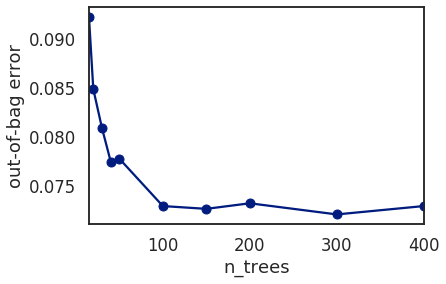

In [20]:
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o')
ax.set(ylabel='out-of-bag error')

In [21]:
rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=True)

In [0]:
# Random forest with 300 estimators
model = RandomForestClassifier(oob_score=False,
                               random_state=42,
                               n_estimators=300,
                               n_jobs=1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [23]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

cr = classification_report(y_test, y_pred)
print(cr)

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred),
                         'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                         'auc': roc_auc_score(y_test, y_pred)},
                        index=pd.Index([0]))
print(score_df)

              precision    recall  f1-score   support

       False       0.93      1.00      0.96      1288
        True       0.95      0.55      0.69       212

    accuracy                           0.93      1500
   macro avg       0.94      0.77      0.83      1500
weighted avg       0.93      0.93      0.92      1500

   accuracy  precision   recall        f1       auc
0     0.932    0.95082  0.54717  0.694611  0.771256


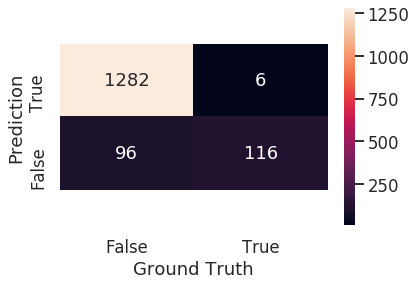

In [24]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

labels = ['False', 'True']
ax.set_xticklabels(labels);
ax.set_yticklabels(labels[::-1]);
ax.set_ylabel('Prediction');
ax.set_xlabel('Ground Truth')

# This has to be done for a bug in seaborn\matplotlib which should get fixed with matplotlib 3.1.2
b, t = ax.get_ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
ax.set_ylim(b, t); # update the ylim(bottom, top) values

In [26]:
sns.__version__

'0.9.1'

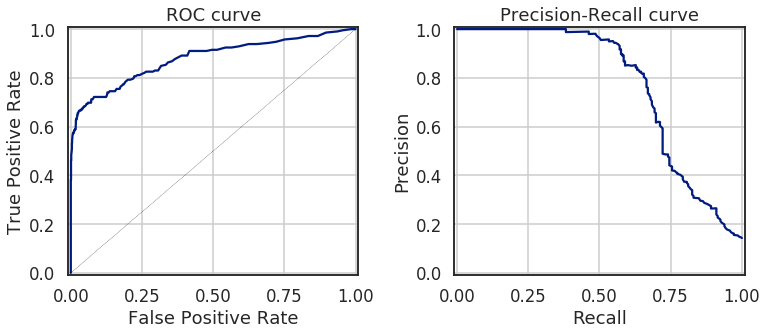

In [30]:
sns.set_context('talk')

fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(11, 5)

# Get the probabilities for each of the two categories
y_prob = model.predict_proba(X_test)

# Plot the ROC-AUC curve
ax = axList[0]

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr, tpr)
# It is customary to draw a diagonal dotted line in ROC plots.
# This is to indicate completely random prediction. Deviation from this
# dotted line towards the upper left corner signifies the power of the model.
ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='ROC curve')
ax.grid(True)

# Plot the precision-recall curve
ax = axList[1]

precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
ax.plot(recall, precision)
ax.set(xlabel='Recall', ylabel='Precision',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='Precision-Recall curve')
ax.grid(True)

plt.tight_layout()